# Transition path theory tutorial

***This notebook is not complete!***

In this tutorial, we will introduce and illustrate some basic ideas behind **transition path theory (TPT)** ([Vanden-Eijden, 2006](https://link.springer.com/chapter/10.1007/3-540-35273-2_13)), which is used to compute statistics on *ensembles* of reactive trajectories (that are also called **transitions**) between macrostates in the state space. (A related [tutorial](https://github.com/mjyshin/math-tutorials/blob/main/path_integral.ipynb) is on the Onsager-Machlup functional, and a future notebook for TPT on Markov jump processes would be a nice extension.) We will need the following Julia packages:

In [1]:
using Random, Distributions, StatsBase, StatsPlots
using LinearAlgebra, ApproxFun, DifferentialEquations
using Plots, LaTeXStrings

We might also use this propagator operation from the operator exponential [tutorial](https://github.com/mjyshin/math-tutorials/blob/main/operator_exponential.ipynb). (We pick this one instead of the [alternative](https://github.com/mjyshin/math-tutorials/blob/main/alternate_exponential.ipynb), since our operators are not self-adjoint.)

In [2]:
import Base: exp

function exp(L::Operator,B::Operator,t::Real,u0::Fun,n::Integer)
    C = Conversion(domainspace(L),rangespace(L))
    
    perm = [3;2;1;4:n]
    P = I(n)[:,perm]    # permutation matrix
    
    B = B[1:2,1:n]*P    # permuted BCs
    B = B[1:2,1:2]\B    # Gaussian eliminated BCs
    M = C[1:n-2,1:n]*P    # permuted masses
    M = M - M[:,1:2]*B    # remove d.o.f.
    L = L[1:n-2,1:n]*P    # permuted generator
    L = L - L[:,1:2]*B    # remove d.o.f.
    A = M[:,3:n]\L[1:n-2,3:n]    # BC-merged generator
    
    c = P'*u0.coefficients[1:n]    # permuted coeffs
    c0 = exp(A*t)*c[3:n]    # interior coeffs, Eq. (3)
    ∂c = B*c - B[:,3:n]*c0    # BC coeffs
    
    c = P*[∂c;c0]    # de-permuted coeffs
    u = chop(Fun(domain(u0),c))
    
    return u
end

exp(L::Operator,B::Operator,t::Real,u0::Fun) = exp(L,B,t,u0,ncoefficients(u0))
exp(L::Operator,B::Operator,t::Real,u0::Fun,tol::Real) = exp(L,B,t,u0,ncoefficients(chop(u0,tol)))

exp (generic function with 40 methods)

Before we venture into the nomenclature of TPT, we should review some useful notions from stochastic processes in 1D, namely the forward and backward generators of the process (as we will use them quite a bit).

## Background on stochastic processes

We define a one-parameter semigroup of operators (called the **Markov semigroup**) on an arbitrary *bounded* observable $f$ on the stochastic process $X_t\in\Omega:=\mathbb{R}$ (this is sloppy notation) as the conditional expectation

$$
(T_tf)(x) := \mathbb{E}[f(X_t)\vert X_0 = x]
$$

with the identity $I=T_0$ and the infinitesimal generator of $T_t$

$$
\mathcal{L}f := \lim_{t\to 0^+}\frac{T_tf - f}{t}.
$$

If we define a time dependent function $u(x,t) := (T_tf)(x)$, we can easily derive that $u$ observes the PDE (called the **backward Kolmogorov equation (BKE)**)

$$
\begin{align*}
\frac{\partial u}{\partial t} &= \mathcal{L}u\\
u(x,0) &= f(x)
\end{align*}\label{eq:bke}\tag{1}
$$

by using the chain rule and the fact that $T_t = e^{t\mathcal{L}}$ by the general property of semigroups of operators. We can therefore think of the KBE as the dynamics of arbitrary *moments* of the process $X_t$. If we expand $u(x,t) = \int_\Omega f(x)\rho(x,t)\,\text{d}x$ and apply $T_t$ to $f$ we get

$$
\int_\Omega(T_tf)(x)\rho(x,t)\,\text{d}x = \int_\Omega f(x)(T_t^\ast\rho)(x,t)\,\text{d}x,
$$

where $T_t^\ast$ is the formal adjoint of $T_t$ with generator $\mathcal{L}^\ast$ (which is the adjoint of $\mathcal{L}$) that observes the PDE (called the **forward Kolmogorov equation (FKE)**) on the probability density $\rho$ of the process $X_t$:

$$
\begin{align*}
\frac{\partial\rho}{\partial t} &= \mathcal{L}^\ast\rho\\
\rho(x,0) &= \rho_0(x),
\end{align*}\label{eq:fke}\tag{2}
$$

given some initial density $\rho_0$. For a (time-)homogeneous diffusion process with drift, the above FKE is the famous **Fokker-Planck equation (FPE)** where we have the functional form

$$
\mathcal{L}^\ast = -\frac{\partial}{\partial x}\left(\mu(x)\,\cdot\right) + \frac{1}{2}\frac{\partial^2}{\partial x^2}\left(\sigma(x)^2\,\cdot\right).
$$

Using integration by parts on $\langle f,\mathcal{L}^\ast\rho \rangle = \langle \mathcal{L}f,\rho \rangle$ (and the fact that $f$ is bounded, therefore disappearing on $\partial\Omega$), we arrive at the functional form of the KBE for the diffusion process with drift:

$$
\mathcal{L} = \mu(x)\frac{\partial}{\partial x} + \frac{1}{2}\sigma(x)^2\frac{\partial^2}{\partial x^2}.
$$

### Mathematical model

Let's illustrate this with a simple case of overdamped dynamics on a double-well potential and constant noise

$$
\mu(x) := -V'(x),\quad \sigma(x) := \sqrt{2D},
$$

where $V(x) = \frac{1}{\epsilon}\left(\frac{x^4}{4} - \frac{x^2}{2} - \alpha x\right)$ is the potential function and $D$ is the diffusion constant. We'll let $\epsilon=0.1$ and $\alpha=0.1$ for concreteness. Let's visualize $V(x)$, noting that it does not depend on $D$:

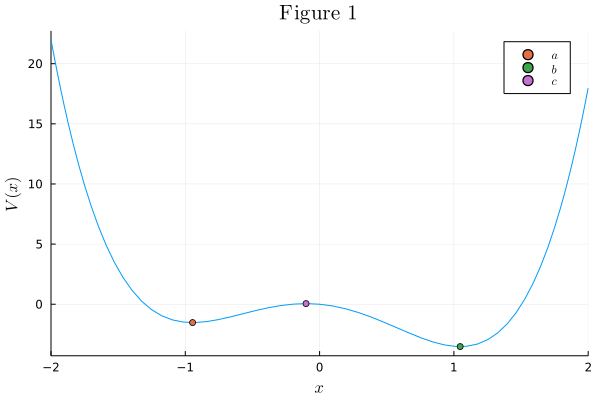

In [3]:
ϵ,α = 0.1,0.1
xmin,xmax = -2,2
Ω = Chebyshev(xmin..xmax)
V = Fun(x->(x^4/4 - x^2/2 - α*x)/ϵ,Ω)
a,c,b = roots(V')

xlims = (xmin,xmax)
title(n) = L"\textrm{Figure\,\ %$n}"
fig = plot(V,title=title(1),label=false,fmt=:png)
fig = scatter!([a],[V(a)],label=L"a",xlims=xlims)
fig = scatter!([b],[V(b)],label=L"b",xlabel=L"x")
fig = scatter!([c],[V(c)],label=L"c",ylabel=L"V(x)")

From Fig. 1, we can imagine that the process $X_t$ would jump between the two wells (called **metastable states** that are locally stable) centered around $x=a\approx-1$ and $x=b\approx1$ due to the diffusive noise, but generally spend more time in the former well due to its lower energy (unless the noise absolutely dominates the dynamics). To see this more clearly, let's simulate one such trajectory of $X_t$.

The corresponding SDE for this process is

$$
\begin{align*}
\text{d}X_t &= \underbrace{-V'(X_t)}_{\mu(X_t,t)}\,\text{d}t + \underbrace{\sqrt{2D}}_{\sigma(X_t,t)}\,\text{d}W_t\\
X_0 &= x_0,
\end{align*}\label{eq:sde}\tag{3}
$$

where $W_t$ is the standard Wiener process with $\text{d}W_t \sim \mathcal{N}(0,\text{d}t)$.

In [4]:
μ(x,θ,t) = -(x^3 - x - θ.α)/θ.ϵ
σ(x,θ,t) = √(2θ.D)

σ (generic function with 1 method)

We'll also set the diffusion at $D=2$ and run the SDE in the time domain $\mathbb{T}=[0,100]$ from the initial state $x_0=0$.

In [5]:
D = 2
θ = (ϵ=ϵ,α=α,D=D)
tspan = (0.0,100.0)
x0 = 0

0

We can sample from Eq. ([3](#mjx-eqn-eq:sde)) with the problem parameters above and plot the trajectory as a function of time:

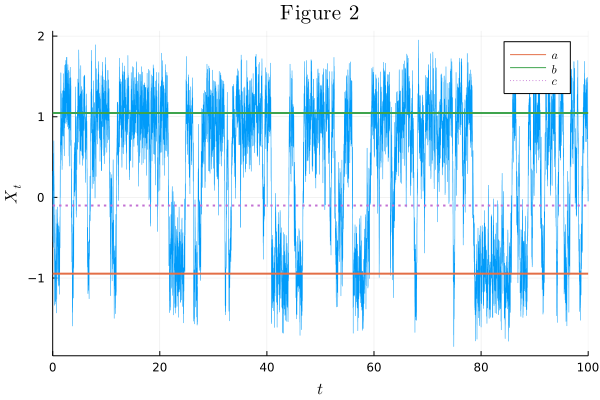

In [6]:
Random.seed!(1)
prob = SDEProblem(μ,σ,x0,tspan,θ)
x = solve(prob)

fig = plot(x,width=0.5,label=false)
fig = hline!([a],width=2,label=L"a",xlabel=L"t",ylabel=L"X_t")
fig = hline!([b],width=2,label=L"b",title=title(2))
fig = hline!([c],width=2,style=:dot,label=L"c",fmt=:png)

Just as we intuitively predicted, $X_t$ seems to "prefer" the right well around $x=a$. We can consider the jump from the left well to the right, by crossing the energy barrier $c$, to be a "rare transition". Some motivating examples of this are: disease progression, extreme climate events, conformational changes of enzymes, and economic shocks.

## Introduction to transition path theory

As we introduced in the very beginning, TPT is a formalism to compute useful statistics on "transitions", which we will now formally define. There are lots of terms, so try not to get too flustered if it's a bit confusing at first!

The first question we ask is: *Where is this transition to and from?* To answer this, we will define two macrostates in $\Omega$ to the left of the left well and to the right of the right well in Fig 1.

$$
A := \{x\in\Omega:x\leq a\},\quad B := \{x\in\Omega\setminus A:x\geq b\},
$$

as well as two functions on $\mathbb{T}$ denoting *when $X_t$ was last at $A$/$B$* and *when $X_t$ will next be at $A$/$B$*:

$$
\tau_0(t) := \sup\{\tau\leq t:X_\tau\in A\cup B\},\quad \tau_f(t) := \inf\{\tau\geq t:T_\tau\in A\cup B\}.
$$

Note that if $X_t\in A\cup B$, then $\tau_0(t)=\tau_f(t)=t$. Finally, we also define a **reaction** (or "reactive trajectory" or "transition") to be a path that *begins at $A$* and *ends at $B$*. Then we can call

$$
\mathcal{X}_R := \{X_t\in\Omega\setminus(A\cup B):t\in \mathbb{T}_R\}
$$

the *ensemble* of reactive trajectories, where

$$\mathbb{T}_R := \{t\in\mathbb{T}:X_{\tau_0(t)}\in A,X_{\tau_f(t)}\in B\}$$

is the set of times that $X_t$ is undergoing a reaction. (In layman's term, the first condition simply says $X_t$ came from $A$, and the second condition that $X_t$ is going to $B$.) By this definition, trajectories that *don't* count as transitions are those that go from $A$ to $A$, from $B$ to $B$, and from $B$ to $A$. As such, we would define sets $A$ and $B$ to be macrostates of interest, depending on the application at hand.

Now that we have that out of the way, let's briefly introduce three statistics we can compute on $\mathcal{X}_R$:

- Reactive trajectory $\pi_R$, describing the equilibrium density of $X_t\in\mathcal{X}_R$,
- Reactive flux $\textbf{j}_R$, describing the current/flow through a dividing surface out of $A$ towards $B$, and
- Reaction rate $r_R$, describing how "quickly" a typical transition takes place.

In order to compute these, however, we need three auxiliary functions: the equilibrium density $\pi$, forward committor $q_+$, and backward committor $q_-$. In the next six subsections, we will go over the definitions of and compute these six functions.

### Equilibrium density

As stated above, the probability density of the process $X_t$ follows the FKE ([2](#mjx-eqn-ex:fke)). Let's get the adjoint generator in a friendlier form for numerical computation. Using the chain rule, we get

$$
\begin{align*}
\mathcal{L}^\ast &= \frac{\partial}{\partial x}\left(V'\,\cdot\right) + D\frac{\partial^2}{\partial x^2}\\
&= V'' + V'\frac{\partial}{\partial x} + D\frac{\partial^2}{\partial x^2}.
\end{align*}
$$

The BCs are $\rho(x,t)\xrightarrow{x\to\pm\infty}0$ as we have the normalization constraint $\int_\Omega\rho(x,t)\,\text{d}x=1$, but since the potential $V(x)$ is already pretty high at $\lvert x \rvert>2$, we will set Dirichlet BCs at those "numerical boundaries", $x_\min$ and $x_\max$. Since we are interested in the long-term behavior of the density $\rho$, we can arbitrarily set the initial density $\rho_0$ as, say, $x\sim\mathcal{N}(\mu_0,\sigma_0^2)$.

In [7]:
𝒟x = Derivative(Ω)
ℒᵀ = V'' + V'*𝒟x + D*𝒟x^2
ℬ = [ldirichlet(Ω);rdirichlet(Ω)]
∑ = DefiniteIntegral(Ω)
μ0,σ0 = 0,0.5
ρ0 = Fun(x->1/√(2π*σ0^2)*exp(-(x-μ0)^2/(2σ0^2)),Ω)

Fun(Chebyshev(-2..2),[0.16516363700114997, 0.0, -0.2852450701390882, 0.0, 0.18770473893275585, 0.0, -0.09754033120633235, 0.0, 0.041394242123257326, 0.0  …  0.0, 1.4755281862849331e-12, 0.0, -1.5371685739927202e-13, 0.0, 1.522613686079408e-14, 0.0, -1.4481681006350594e-15, 0.0, 1.307480057381738e-16])

For appropriate potentials $V(x)$, the density approaches a limit called the **equilibrium density** $\rho(\cdot,t)\xrightarrow{t\to\infty}\pi$. Since $\pi$ is stationary with respect to time, we have $\frac{\partial\pi}{\partial t} = 0 = \mathcal{L}^\ast\pi$. The BCs and normalization constraint remain, so we get a boundry value PDE (ODE in 1D) for $\pi$:

$$
\begin{align*}
\mathcal{L}^\ast\pi &= 0,\quad x\in\Omega\\
\pi(x) &= 0,\quad x\in\partial\Omega\\
\int_\Omega\pi(x)\,\text{d}x &= 1.
\end{align*}\label{eq:eqdens}\tag{4}
$$

The analytical solution to the above equilibrium FKE is the Gibbs measure of $X_t$ at thermal equilibrium

$$
\pi(x) = Z^{-1}e^{-\frac{V(x)}{D}},
$$

where $Z = \int_\Omega e^{-\frac{V(x)}{D}}\,\text{d}x$ is the partition function. Let's plot the solution to Eq. ([2](#mjx-eqn-eq:fke)) at various $t$, as well as the numerical and analytical solutions to Eq. ([4](#mjx-eqn-eq:eqdens)).

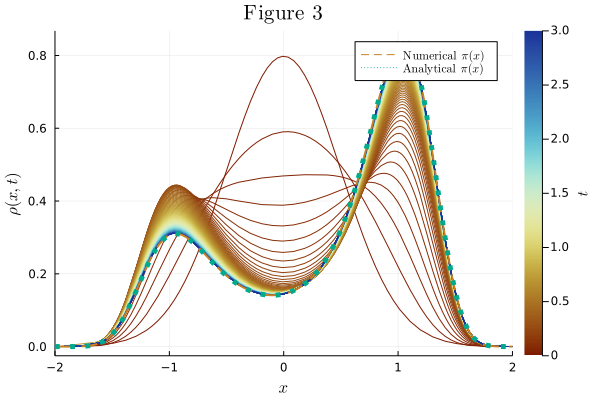

In [8]:
t = 0:0.02:3
ρ = exp.(Ref(ℒᵀ),Ref(ℬ),t,Ref(ρ0))    # PDE solution
#πⁿ = [∑;ℬ;ℒᵀ]\[1;0;0;0]    # computationally very expensive
πⁿ = [ℬ;ℒᵀ]\[eps();eps();0]    # numerical w/o normalization
πⁿ = πⁿ/sum(πⁿ)    # normalization constraint
πᵃ = exp(-V/D)/sum(exp(-V/D))    # analytical solution

fig = plot(xlims=xlims,xlabel=L"x",ylabel=L"\rho(x,t)",title=title(3),fmt=:png)
fig = plot!(ρ,line_z=t',color=:roma,cbar=true,cbartitle=L"t",label=false)
fig = plot!(πⁿ,width=2,style=:dash,label=L"\textrm{Numerical\,\ }\pi(x)")
fig = plot!(πᵃ,width=5,style=:dot,label=L"\textrm{Analytical\,\ }\pi(x)")

What does this tell us (that is, how should we *interpret* this statistic)? The equilibrium density $\pi(x)$ is the long-run (i.e., as $\mathbb{T}\to\mathbb{R}_+$) probability density for finding the diffusion process $X_t$ at $[x,x+\text{d}x)$. To approximate this, let's run the SDE ([3](#mjx-eqn-eq:sde)) in $\mathbb{T} = [0,1000]$:

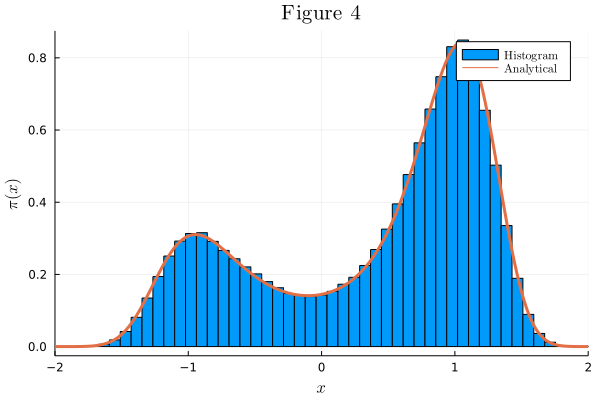

In [9]:
Random.seed!(2)
Δt = 1e-4
bins = range(xmin,xmax,50)
X = solve(remake(prob,tspan=(0.0,1000.0)),maxiters=Int(1e7),saveat=Δt)
h1 = normalize(fit(Histogram,X.u,bins))

fig = plot(xlabel=L"x",ylabel=L"\pi(x)",title=title(4))
fig = plot!(h1,label=L"\textrm{Histogram}",xlims=xlims)
fig = plot!(πᵃ,width=3,label=L"\textrm{Analytical}",fmt=:png)

The problem with this is the practicality of simulating an infinitely long trajectory. For instance, what if we start in a particular $X_0$ that was located in an especially deep well with low noise? Even if we simulate it for a very long time, we might never escape it!

Put in another light, we can also think of $\pi$ as the probability density of the unrestricted *ensemble* of all trajectories $\mathcal{X}:=\{X_t\in\Omega:t\in\mathbb{T}\}$. That is, instead of running a single, long simulation, we can run many shorter simulations (an ensemble) to find the density. One issue is to choose the initial condition, but despite our *a priori* ignorance (choose from a uniform prior), if we run each simulation for a sufficiently long time, the hope is that most of the state space will be $\pi$-proportionately visited. The fact that a variety of $X_0$ is used means that even less-likely wells have a better chance of being sampled than before. Another advantage of this is parallelizeability.

To illstrate this, we will draw $n=100$ samples of $X_0\stackrel{\text{i.i.d.}}{\sim}\text{Unif}(x_\min,x_\max)$ as simple guesses. Next we run each simulation in $\mathbb{T} = [0,50]$ (five such trajectories are plotted in Fig. 5), noting that $\rho$ in Fig. 3 seems to equilibrate rather quickly by $t\approx3$ (this is the case even with a much narrower prior).

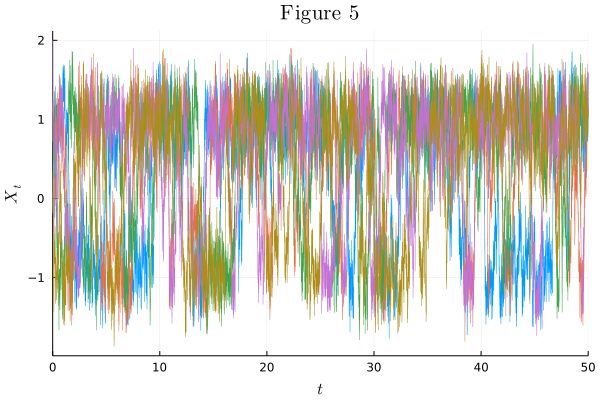

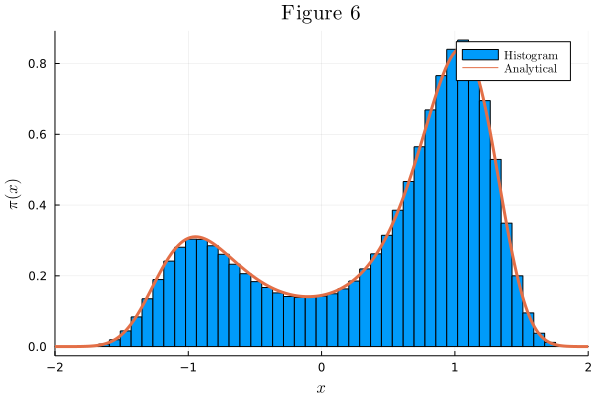

In [10]:
Random.seed!(3)
n,tf = 100,50.0
X0 = rand(Uniform(xmin,xmax),n)
𝒳 = [solve(remake(prob,u0=X0[i],tspan=(0.0,tf)),saveat=Δt).u for i ∈ 1:n]
hn = normalize(merge(fit.(Histogram,𝒳,Ref(bins))...))

fig = plot(xlabel=L"t",ylabel=L"X_t",title=title(5),fmt=:png)
fig = plot!(0:Δt:tf,𝒳[1:5],width=0.5,label=false,xlims=(0,tf))
display(fig)

fig = plot(xlabel=L"x",ylabel=L"\pi(x)",title=title(6))
fig = plot!(hn,label=L"\textrm{Histogram}",xlims=xlims)
fig = plot!(πᵃ,width=3,label=L"\textrm{Analytical}",fmt=:png)
display(fig)

If we take this alternate view to the extreme (i.e., $\mathbb{T}\to\{0\}$), the prior on $X_0$ becomes increasingly/infinitely important, and we basically end up *sampling from $\pi$ itself*.

---

#### Brief interlude in sampling

This subsection could definitely be a notebook of its own, but since we mentioned sampling from a distribution, let's just quickly illustrate two methods to sample from arbitrary distribution, i.e., given a(n unnormalized) pdf: Rejection sampling and the Metropolis-Hastings algorithm.

**Rejection sampling** is a very inefficient algorithm, where we pick random points in the sample space and randomly decide to keep them proportional to the desired pdf. The **Metropolis-Hastings** algorithm, on the other hand, is a **Markov chain Monte Carlo (MCMC)** technique that utilizes the concept of detailed balance&mdash;$p(y\vert x)\pi(x) = p(x\vert y)\pi(y)$&mdash;to more efficiently accept samples by "moving around" in the sample space (the titular "Markov chain" part) with a transition density $p$.

In [11]:
function rejection(f::Fun,N::Int)
    Ω = domain(f)
    a,b = Ω.left,Ω.right
    M = maximum(f)
    X = []
    while length(X) < N
        x = rand(Uniform(a,b))
        r = rand(Uniform(0,M))
        if r < f(x) push!(X,x) end
    end
    return X
end

function metropolis(f::Fun,N::Int,σ::Real)
    Ω = domain(f)
    a,b = Ω.left,Ω.right
    X = [rand(Uniform(a,b))]
    while length(X) < N
        x = X[end]
        y = x + rand(Normal(0,σ))
        if y ∈ Ω
            α = f(y)/f(x)
            if rand() < α push!(X,y)
            else push!(X,x) end
        else push!(X,x) end
    end
    return X
end

Random.seed!(4)
M,N = 5,Int(1e6)
@time begin for i ∈ 1:M rejection(πⁿ,N) end end
@time begin for i ∈ 1:M metropolis(πⁿ,N,0.5) end end

 12.436114 seconds (67.60 M allocations: 1.519 GiB, 2.90% gc time, 52.12% compilation time)
  1.225401 seconds (136.88 k allocations: 55.984 MiB, 11.60% gc time, 9.82% compilation time)


We can see the inefficiencies of rejection sampling compared to the simple MCMC method first hand.

---

In this last view of $\pi$, we run a very large number of "simulations of length 0", but this is rather useless as we need to know the underlying equilibrium density $X_0\stackrel{\text{i.i.d.}}{\sim}\pi$.

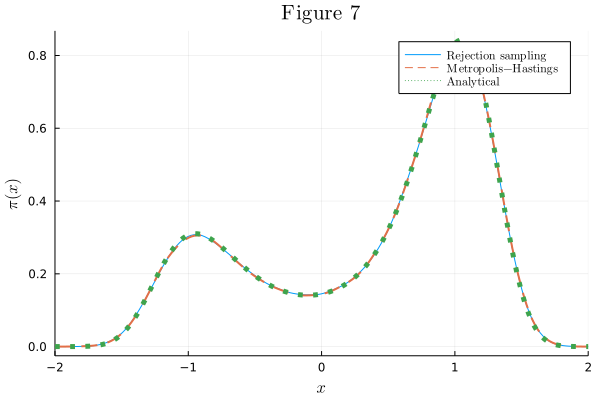

In [12]:
Random.seed!(5)
X0rs = rejection(πᵃ,N)
X0mh = metropolis(πᵃ,N,0.5)

fig = density(X0rs,xlabel=L"x",ylabel=L"\pi(x)",label=L"\textrm{Rejection\,\ sampling}",xlims=xlims)
fig = density!(X0mh,width=2,style=:dash,label=L"\textrm{Metropolis\hspace{-.3}-\hspace{-.4}Hastings}")
fig = plot!(πᵃ,width=5,style=:dot,label=L"\textrm{Analytical}",title=title(7),fmt=:png)

### Forward committor

The equilibrium density alone doesn't tell us anything about about transitions, since it includes trajectories from $A$ to $A$, from $B$ to $B$, and from $B$ to $A$. To limit our analysis to trajectories $X_t\in\mathcal{X}_R$, it needs to meet the three criteria:

- $X_t\in\Omega\setminus(A\cup B)$,
- $X_{\tau_0(t)}\in A$, and
- $X_{\tau_f(t)}\in B$.

The first criterion can be achieved by simply limiting the space to $\Omega\setminus(A\cup B)$. We'll wait for the next section to worry about the second. To satisfy the third criterion, we ask ourselves: For a process $X_t \in \Omega\setminus(A\cup B)$, will it hit $B$ before it hits $A$? Of course, given the random nature of the dynamics, there's no way to know for sure; therefore, we relegate to answering that question probabilistically.

The **forward committor** $q_+$ is the long-run probability that a process $X_t \in \Omega\setminus(A\cup B)$ will next hit $B$. Mathematically, this is expressed as

$$
q_+(x) := \mathbb{P}\left\{X_{\tau_f(0)} \in B\,\middle|\,X_0=x\right\},\quad x\in\Omega\setminus(A\cup B),
$$

where we have recentered to $t=0$ given the autonomous nature of our process $X_t$. Note that this probability can be expressed as an expectation on an indicator function:

$$
q_+(x) = \mathbb{E}\left[\mathbb{1}_B\left(X_{\tau_f(0)}\right)\,\middle|\,X_0=x\right].
$$

This looks reminiscent of the Markov semigroup applied to $\mathbb{1}_B$, but we're not quite there. Let's look at the committor probability a small $t$ time after we've observed that $X_0 = x$. We get $q_+(x') = \mathbb{E}\left[\mathbb{1}_B\left(X_{\tau_f(t)}\right)\;\middle|\; X_t=x'\right]$ We can then formulate $q_+(x)$ as an infinite sum over all possible $x'$:

$$
q_+(x) = \int_{\Omega\setminus(A\cup B)}q_+(x')p(x',t\vert x)\,\text{d}x',
$$

where $p(x',t\vert x)$ is the transition probability from $X_0=x$ to $X_t=x'$. This formulation is itself a conditional expectation

$$
q_+(x) = \mathbb{E}[q_+(X_t)\vert X_0=x]=:(T_tq_+)(x),
$$

and exactly what we want! If we define $u(x,t) := (T_tq_+)(x)$, we get that it observes the BKE ([1](#mjx-eqn-eq:bke)) with the forward committor as the IC and BCs of $q_+(a) = 0$ and $q_+(b) = 1$ from the definitions of the forward committor, $A$, and $B$.

In [13]:
Ωᴿ = Chebyshev(a..b)    # Ω\(A∪B)
Vᴿ = Fun(x->(x^4/4 - x^2/2 - α*x)/ϵ,Ωᴿ)    # V(x) in Ω\(A∪B)
𝒟xᴿ = Derivative(Ωᴿ)    # 𝒟ₓ in Ω\(A∪B)
ℒ = -Vᴿ'*𝒟xᴿ + D*𝒟xᴿ^2
ℬᴿ = [ldirichlet(Ωᴿ);rdirichlet(Ωᴿ)]    # BCs at ∂A and ∂B

InterlaceOperator : Chebyshev(-0.9456492739235908..1.0466805318046022) → 2-element ArraySpace:
ConstantSpace{DomainSets.Point{Float64}, Float64}[ConstantSpace(Point(-0.9456492739235908)), ConstantSpace(Point(1.0466805318046022))]
 1.0  -1.0  1.0  -1.0  1.0  -1.0  1.0  -1.0  1.0  -1.0  ⋯
 1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0  ⋯

That doesn't seem very helpful since we need to input the solution as the IC. But notice that, by the definition we arrived at above, $q_+$ is invariant under the map $T_t$. So, we need only to solve the boundary value ODE (in 1D):

$$
\begin{align*}
\mathcal{L}q_+ &= 0,\quad x\in\Omega\setminus(A\cup B)\\
q_+(x) &= 0,\quad x\in\partial A:=\{a\}\\
q_+(x) &= 1,\quad x\in\partial B:=\{b\}.
\end{align*}\label{eq:fcomm}\tag{5}
$$

The analytical solution to the equation above is the quadrature

$$
q_+(x) = C^{-1}\int_a^xe^{\frac{V(\xi)}{D}}\,\text{d}\xi,
$$

where $C = \int_a^be^{\frac{V(\xi)}{D}}\,\text{d}\xi$ is the normalizing constant for the total probability. We'll compare the numerical and analytical solutions to Eq. ([5](#mjx-eqn-eq:fcomm)).

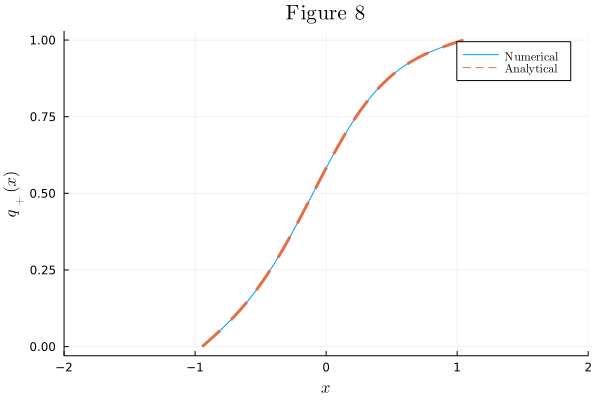

In [14]:
q₊ⁿ = [ℬᴿ;ℒ]\[0;1;0]
q₊ᵃ = cumsum(exp(Vᴿ/D))/sum(exp(Vᴿ/D))

fig = plot(xlabel=L"x",ylabel=L"q_+(x)",title=title(8))
fig = plot!(q₊ⁿ,label=L"\textrm{Numerical}",xlims=xlims,fmt=:png)
fig = plot!(q₊ᵃ,width=3,style=:dash,label=L"\textrm{Analytical}")

This result is easy enough to interpret, but let's check the solution with an intuitive simulation. Namely, we want to run the SDE ([3](#mjx-eqn-eq:sde)) some large $n$ number of times from $X_0 = x \in \Omega\setminus(A\cup B)$ in some long (enough) time domain $\mathbb{T}$, but terminate when $X_t\in A\cup B$. We count the numbers of simulations $n_A$ and $n_B$ that end in $A$ and $B$, respectively, and divide the latter count from the sum of the two.

Let's illustrate this with $n=20$ and $x=0$:

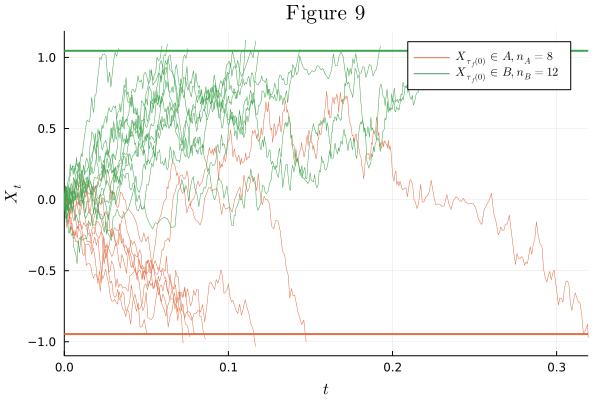

In [15]:
Random.seed!(5)
condition(u,t,integrator) = u[1] ≤ a || u[1] ≥ b
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition,affect!)

X₊ = [solve(prob,callback=cb) for i ∈ 1:20]
t₊A,t₊B = [],[]
X₊A,X₊B = [],[]
for x₊ ∈ X₊
    if x₊[end] ≤ a
        push!(t₊A,x₊.t)
        push!(X₊A,x₊.u)
    elseif x₊[end] ≥ b
        push!(t₊B,x₊.t)
        push!(X₊B,x₊.u)
    end
end
n₊A,n₊B = length(X₊A),length(X₊B)

t₊f = maximum(maximum.([t₊A;t₊B]))
labelA = permutedims([L"X_{\tau_f(0)} \in A,n_A=%$(n₊A)";repeat([false],max(n₊A-1,0))])
labelB = permutedims([L"X_{\tau_f(0)} \in B,n_B=%$(n₊B)";repeat([false],max(n₊B-1,0))])
fig = plot(xlims=(0,t₊f),xlabel=L"t",ylabel=L"X_t",title=title(9),fmt=:png)
fig = plot!(t₊A,X₊A,width=0.5,color=palette(:default)[2],label=labelA)
fig = plot!(t₊B,X₊B,width=0.5,color=palette(:default)[3],label=labelB)
fig = hline!([a b],width=2,color=palette(:default)[2:3]',label=false)

In this example, we get the estimate $\hat q_+^{20}(0) = 0.6$. Increasing the number of runs to $n = 100$ and repeating it for an $m=100$-point grid $\mathbf{x} = (x_1=a,\dots,x_m=b)$, we get an estimate of the forward commitor $q_+(x)\approx \hat{\mathbf{q}}_+^n(\mathbf{x}) = \left(\hat q_+^n(x_1),\dots,\hat q_+^n(x_m)\right)$ that we can compare to the analytical solution obtained above.

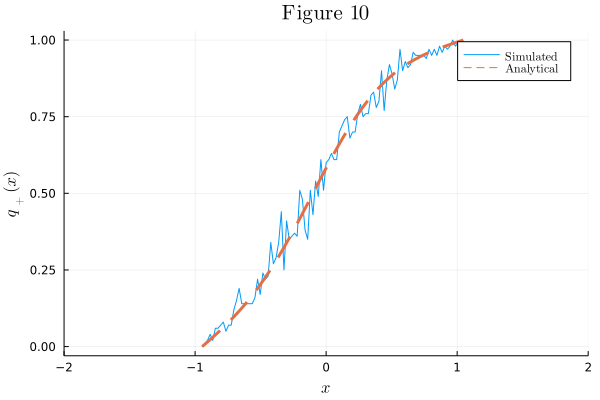

In [16]:
function q̂₊(x::Real,a::Real,b::Real,n::Int,prob::SDEProblem,cb::DiscreteCallback)
    xf = [solve(remake(prob,u0=x),callback=cb)[end] for i ∈ 1:n]
    nA = sum(xf .≤ a)
    nB = sum(xf .≥ b)
    return nB/(nA+nB)
end

Random.seed!(6)
m = 100
X₊ = range(a,b,m)
Q̂₊ = [q̂₊(x₊,a,b,n,prob,cb) for x₊ ∈ X₊]
fig = plot(X₊,Q̂₊,xlims=xlims,xlabel=L"x",ylabel=L"q_+(x)",label=L"\textrm{Simulated}")
fig = plot!(q₊ᵃ,width=3,style=:dash,label=L"\textrm{Analytical}",title=title(10),fmt=:png)

### Backward committor

$$
\mathcal{L}^-f := \lim_{t\to0^+}\frac{T_{-t}f-f}{t}
$$

$$
\mathcal{L}^-f = \frac{1}{\pi}\mathcal{L}^\ast(\pi f)
$$

$$
\begin{align*}
\pi\mathcal{L}^- &= \frac{\partial}{\partial x}\left(V'\pi\,\cdot\right) + D\frac{\partial^2}{\partial x^2}(\pi\,\cdot)\\
&= (V'\pi)' + V'\pi\frac{\partial}{\partial x} + D\frac{\partial}{\partial x}\left(\pi'\,\cdot + \pi\frac{\partial}{\partial x}\,\cdot\right)\\
&= V''\pi + V'\pi' + V'\pi\frac{\partial}{\partial x} + D\left[ \pi'' + 2\pi'\frac{\partial}{\partial x} + \pi\frac{\partial^2}{\partial x^2}\right].
\end{align*}
$$

In [17]:
πᴿⁿ = Fun(x->πⁿ(x),Ωᴿ)    # numerical π(x) in Ω\(A∪B)
ℒ⁻ = Vᴿ'' + Vᴿ'*πᴿⁿ'/πᴿⁿ + Vᴿ'*𝒟xᴿ + D*(πᴿⁿ''/πᴿⁿ + 2πᴿⁿ'/πᴿⁿ*𝒟xᴿ + 𝒟xᴿ^2)
ℒᵀᴿ = Vᴿ'' + Vᴿ'*𝒟xᴿ + D*𝒟xᴿ^2    # ℒ* in Ω\(A∪B)

PlusOperator : Chebyshev(-0.9456492739235908..1.0466805318046022) → Ultraspherical(2,-0.9456492739235908..1.0466805318046022)
 -4.96172256849118   -0.7548284489495597   …    ⋅                  ⋅
  0.754828448949564  -1.2404306421227966        ⋅                  ⋅
  2.480861284245586   0.37741422447478196       ⋅                  ⋅
   ⋅                  1.2404306421227933      -1.2404306421227935  ⋅
   ⋅                   ⋅                      -0.377414224474782   ⋱
   ⋅                   ⋅                   …   2.4808612842455906  ⋱
   ⋅                   ⋅                       1.1322426734243418  ⋱
   ⋅                   ⋅                      36.27772361620307    ⋱
   ⋅                   ⋅                      -1.1322426734243418  ⋱
   ⋅                   ⋅                      -2.48086128424559    ⋱
   ⋅                   ⋅                   …    ⋱                  ⋱

The PDE for the backward commitor reduces to the boundary value ODE

$$
\begin{align*}
\mathcal{L}^-q_- &= 0,\quad x\in\Omega\setminus(A\cup B)\\
q_-(x) &= 1,\quad x\in\partial A\\
q_-(x) &= 0,\quad x\in\partial B.
\end{align*}\label{eq:bcomm1}\tag{6}
$$



$$
\begin{align*}
\mathcal{L}^\ast\pi q_- &= 0,\quad x\in\Omega\setminus(A\cup B)\\
(\pi q_-)(x) &= \pi(x),\quad x\in\partial A\\
(\pi q_-)(x) &= 0,\quad x\in\partial B
\end{align*}\label{eq:bcomm2}\tag{7}
$$

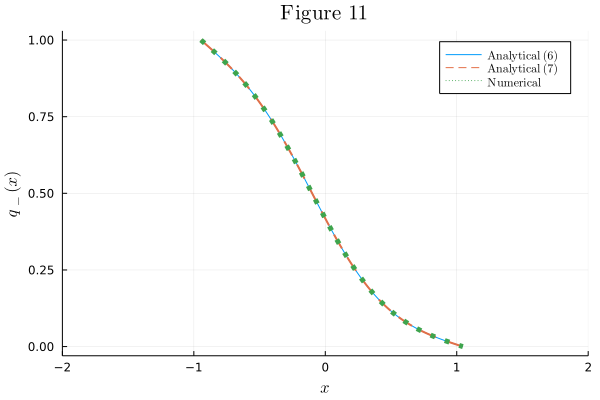

In [18]:
q₋ⁿ¹ = [ℬᴿ;ℒ⁻]\[1;0;0]
q₋ⁿ² = ([ℬᴿ;ℒᵀᴿ]\[πᴿⁿ(a);0;0])/πᴿⁿ
q₋ᵃ = 1 - q₊ᵃ

fig = plot(xlabel=L"x",ylabel=L"q_-(x)",title=title(11))
fig = plot!(q₋ⁿ¹,label=L"\textrm{Analytical\ (6)}",xlims=xlims,fmt=:png)
fig = plot!(q₋ⁿ²,width=2,style=:dash,label=L"\textrm{Analytical\ (7)}")
fig = plot!(q₋ᵃ,width=5,style=:dot,label=L"\textrm{Numerical}")

### Reactive density

$$
\pi_R(x) := Z_R^{-1}\pi(x)q_-(x)q_+(x),\quad x\in\Omega\setminus(A\cup B)
$$

where $Z_R = \int_{\Omega\setminus(A\cup B)}\pi(x)q_-(x)q_+(x)\,\text{d}x$ is the normalizing constant for the probability density such that $\int_{\Omega\setminus(A\cup B)}\pi_R(x)\,\text{d}x = 1$.

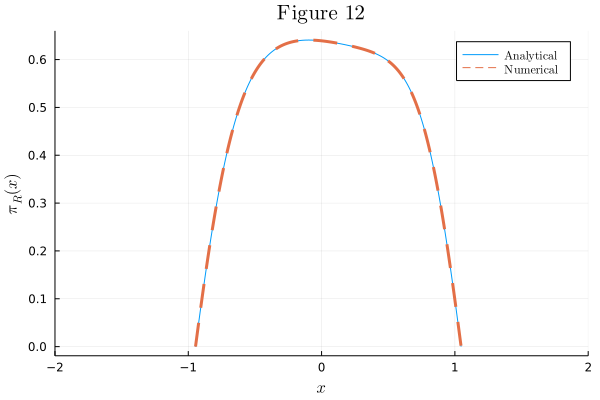

In [19]:
q₋ⁿ = q₋ⁿ¹
πᵣⁿ = πᴿⁿ*q₋ⁿ*q₊ⁿ
πᵣⁿ = πᵣⁿ/sum(πᵣⁿ)

πᴿᵃ = Fun(x->πᵃ(x),Ωᴿ)
πᵣᵃ = πᴿᵃ*q₋ᵃ*q₊ᵃ
πᵣᵃ = πᵣᵃ/sum(πᵣᵃ)

fig = plot(xlabel=L"x",ylabel=L"\pi_R(x)",title=title(12))
fig = plot!(πᵣⁿ,label=L"\textrm{Analytical}",xlims=xlims,fmt=:png)
fig = plot!(πᵣᵃ,width=3,style=:dash,label=L"\textrm{Numerical}")

Given the measure $\pi_R$ we can ask questions like: In the long run, what proportion of time does a transition spend at some (measurable) set $S\subseteq\Omega\setminus(A\cup B)$? The answer to which is

$$
\mathbb{P}\{X_t\in S:X_t\in\mathcal{X}_R\} = \int_S\pi_R(x)\,\text{d}x.
$$

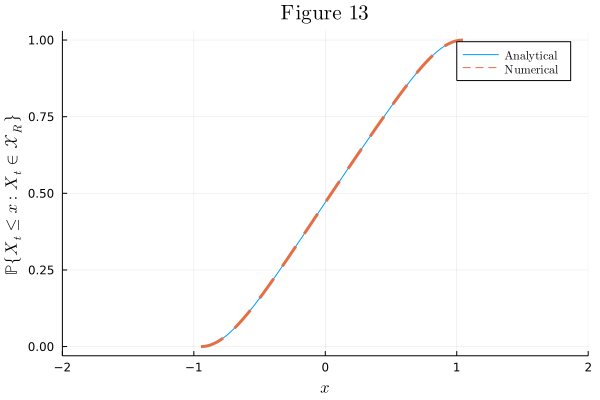

In [20]:
fig = plot(ylabel=L"\mathbb{P}\{X_t\leq x:X_t\in\mathcal{X}_R\,\}",title=title(13))
fig = plot!(cumsum(πᵣⁿ),label=L"\textrm{Analytical}",xlabel=L"x",xlims=xlims)
fig = plot!(cumsum(πᵣᵃ),width=3,style=:dash,label=L"\textrm{Numerical}",fmt=:png)

### Reactive current